# 320to335 (1-15 Dezember)

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from matplotlib import rcParams
import shap
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import seaborn as sns

from catboost import Pool, CatBoostRegressor, cv 
from catboost.utils import eval_metric

# Data

In [2]:
df = pd.read_stata('T:\\COVID19\\Makrodaten\\Dez1-15woPe deaths.dta')


One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.


In [3]:
Y = df['std_leth_AGS_335to350']
X = df.loc[:, ~df.columns.isin(['std_leth_AGS_335to350'])]
f_names = list(X.columns)
print("Number of features: ", len(X.columns))

Number of features:  155


# First CatBoost Model with 155 features

In [4]:
# initialize Pool
train_pool = Pool(X,Y)
 

# specify the training parameters 
model = CatBoostRegressor(random_seed=0, logging_level = 'Silent')
#train the model
cb = model.fit(train_pool)
print("R2 of final model on all data: ",cb.score(X, Y))

R2 of final model on all data:  0.9988754977117256


In [5]:
preds = cb.predict(train_pool,
                    prediction_type="RawFormulaVal"
                  )

print("RMSE of final model on all data: ", eval_metric(Y, preds, 'RMSE')[0])

RMSE of final model on all data:  0.3269703018536253


# SHAP VAlues

In [6]:
shap_values_cb = shap.TreeExplainer(cb).shap_values(X)

def ABS_SHAP(df_shap,df):
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)[-20::]
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
ABS_SHAP(shap_values_cb,X) 

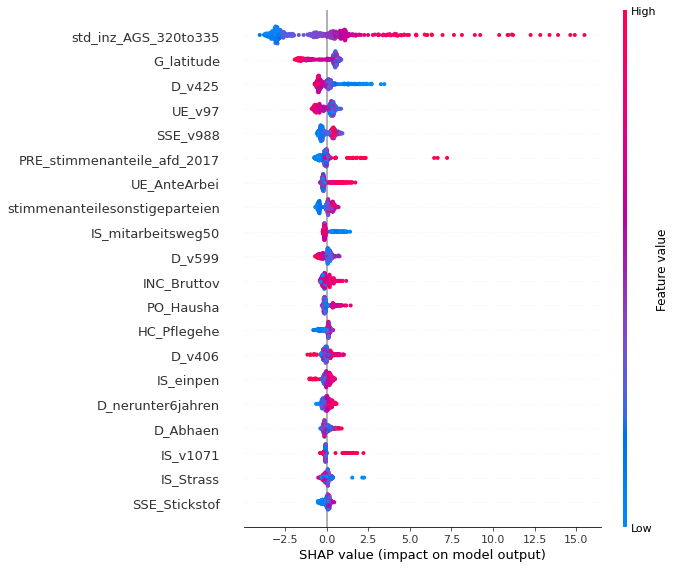

In [7]:
shap.summary_plot(shap_values_cb,X)

# Second CatBoost model with 20 most important features

In [8]:
top20feature = X.columns[np.argsort(np.abs(shap_values_cb).mean(0))][-20:][::-1]
top10feature = X.columns[np.argsort(np.abs(shap_values_cb).mean(0))][-10:][::-1]

In [9]:
# initialize Pool
train_pool_20 = Pool(X[top20feature],Y)
 

# specify the training parameters 
model = CatBoostRegressor(random_seed=0, logging_level = 'Silent')
#train the model
cb_20 = model.fit(train_pool_20)
print("R2 of second model with top20 feature: ",cb_20.score(X[top20feature], Y))

R2 of second model with top20 feature:  0.9944599424081664


In [10]:
preds_20 = cb_20.predict(train_pool_20,
                    prediction_type="RawFormulaVal"
                  )

print("RMSE of second model on top20 data: ", eval_metric(Y, preds_20, 'RMSE')[0])

RMSE of second model on top20 data:  0.7257470450056631


# Compare top 10 features of both Models

In [11]:
shap_values_cb_20 = shap.TreeExplainer(cb_20).shap_values(X[top20feature])

top10feature_from_top_20 = X[top20feature].columns[np.argsort(np.abs(shap_values_cb_20).mean(0))][-10:][::-1]

print("10 most important features from model with all features:", "\n", list(top10feature), "\n\n",
     "10 most important features from model with top20 features:", "\n", list(top10feature_from_top_20)) 

10 most important features from model with all features: 
 ['std_inz_AGS_320to335', 'G_latitude', 'D_v425', 'UE_v97', 'SSE_v988', 'PRE_stimmenanteile_afd_2017', 'UE_AnteArbei', 'stimmenanteilesonstigeparteien', 'IS_mitarbeitsweg50', 'D_v599'] 

 10 most important features from model with top20 features: 
 ['std_inz_AGS_320to335', 'G_latitude', 'UE_v97', 'D_v425', 'SSE_v988', 'PRE_stimmenanteile_afd_2017', 'stimmenanteilesonstigeparteien', 'HC_Pflegehe', 'UE_AnteArbei', 'D_v599']


In [12]:
# features which are on top10 of both models:
for i in top10feature :
    if i in list(top10feature_from_top_20) :
         print(i)

std_inz_AGS_320to335
G_latitude
D_v425
UE_v97
SSE_v988
PRE_stimmenanteile_afd_2017
UE_AnteArbei
stimmenanteilesonstigeparteien
D_v599


ABS_SHAP(shap_values_cb_20,X[top20feature]) 

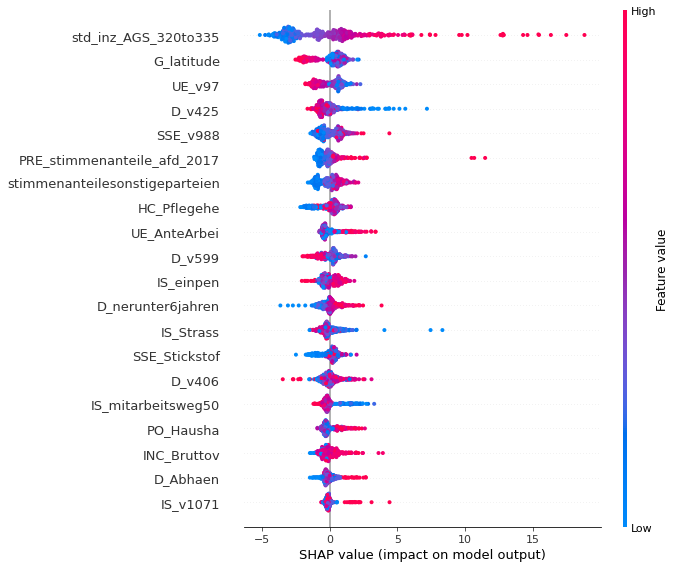

In [13]:
shap.summary_plot(shap_values_cb_20,X[top20feature])

# Hold out validation of the second model

In [14]:
import random
iterations = range(0,20)

r2_reg_k_test_top20 = list(range(0,20))
rmse_reg_k_test_top20 = list(range(0,20))
r2_cb_k_train_top20 = list(range(0,20))
r2_cb_k_test_top20 = list(range(0,20))

for i in iterations:
    rs = random.sample(range(0,401), 80)
    k_test_x = X[top20feature].iloc[rs]
    k_test_y = Y.iloc[rs]
    k_train_x = X[top20feature].drop(rs)
    k_train_y = Y.drop(rs)
    # initialize Pool 
    train_pool_k = Pool(data=k_train_x,
                        label=k_train_y,
                        feature_names = list(X[top20feature].columns))
        
    test_pool_k = Pool(data=k_test_x,
                       label=k_test_y,
                       feature_names = list(X[top20feature].columns))

    
    #fit the model
    model = CatBoostRegressor(random_seed=0,
                              logging_level="Silent",
                              #iterations = scores_k.sort_values(by= "test-R2-mean")["iterations"].iloc[-1]
                             )

    cb_k = model.fit(train_pool_k)
    
    # make the prediction using the resulting model
    preds_k = cb_k.predict(test_pool_k,
                    prediction_type="RawFormulaVal"
                  )
    
    rmse_reg_k_test_top20[i] = eval_metric(np.array(k_test_y), preds_k, "RMSE")[0]
    
    preds_k = preds_k.reshape(-1, 1)
    #LinearRegression
    reg_k = LinearRegression().fit(preds_k, k_test_y)

    
    r2_cb_k_train_top20[i] = cb_k.score(train_pool_k)
    r2_reg_k_test_top20[i] = reg_k.score(preds_k, k_test_y)

    r2_cb_k_test_top20[i] =  cb_k.score(test_pool_k)
    
    print(i/len(iterations)*100,"%", "  " , end="")

0.0 %   5.0 %   10.0 %   15.0 %   20.0 %   25.0 %   30.0 %   35.0 %   40.0 %   45.0 %   50.0 %   55.00000000000001 %   60.0 %   65.0 %   70.0 %   75.0 %   80.0 %   85.0 %   90.0 %   95.0 %   

In [15]:
print("Mean R2 of CatBoost_models on train sets with top20 features:",sum(r2_cb_k_train_top20)/len(r2_cb_k_train_top20))
print("Mean R2 of linReg_modesl with top20 features: ", sum(r2_reg_k_test_top20)/len(r2_reg_k_test_top20))
print("Mean RMSE of CatBoost_models on test sets with top20 features: ", sum(rmse_reg_k_test_top20)/len(rmse_reg_k_test_top20))
print("Mean R2 of CatBoost_models on test sets with top20 features:",sum(r2_cb_k_test_top20)/len(r2_cb_k_test_top20))

Mean R2 of CatBoost_models on train sets with top20 features: 0.996480406912587
Mean R2 of linReg_modesl with top20 features:  0.4520281996950838
Mean RMSE of CatBoost_models on test sets with top20 features:  7.760651517054323
Mean R2 of CatBoost_models on test sets with top20 features: 0.4206318802683325


# descriptives of top20 features

In [16]:
X[top20feature].describe()

,std_inz_AGS_320to335,G_latitude,D_v425,UE_v97,SSE_v988,PRE_stimmenanteile_afd_2017,UE_AnteArbei,stimmenanteilesonstigeparteien,IS_mitarbeitsweg50,D_v599,INC_Bruttov,PO_Hausha,HC_Pflegehe,D_v406,IS_einpen,D_nerunter6jahren,D_Abhaen,IS_v1071,IS_Strass,SSE_Stickstof
count,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000
mean,299.439178,50.615307,5.230676,-8.350625,33367.324219,13.388280,22.971321,5.217952,0.243391,23.700600,2337.790527,21.168577,97.709465,-3.954613,64.508949,11.580301,34.353863,61.763092,491.092896,68.331635
std,144.247375,1.740311,9.954544,18.685120,30681.789062,5.329521,4.190942,1.823041,1.409295,0.656122,806.781372,5.410111,23.278893,4.800081,10.002246,4.918643,5.474822,18.467165,87.669556,27.160891
min,20.302881,47.500000,-32.299999,-51.700001,1062.000000,4.900000,14.500000,2.000000,-5.300000,22.020000,22.000000,9.300000,40.700001,-18.600000,21.700001,-1.600000,22.400000,25.000000,275.799988,21.400000
25%,203.504822,49.283333,-0.700000,-21.000000,15678.000000,9.800000,19.500000,3.800000,-0.400000,23.270000,2245.000000,16.900000,80.400002,-7.500000,58.799999,8.300000,31.000000,47.000000,431.399994,47.500000
50%,286.181732,50.549999,5.100000,-9.300000,24587.000000,12.000000,22.700001,4.700000,0.500000,23.680000,2485.000000,20.799999,96.800003,-4.200000,66.000000,11.900000,33.799999,57.000000,476.399994,59.200001
75%,371.910645,51.849998,11.300000,3.800000,39522.000000,15.300000,25.900000,6.600000,1.100000,24.180000,2733.000000,24.400000,113.900002,-0.300000,71.300003,14.500000,36.900002,79.000000,545.000000,88.199997
max,968.592468,54.783333,35.700001,61.299999,174293.000000,35.500000,34.700001,12.600000,4.200000,25.719999,4254.000000,47.900002,184.899994,11.100000,90.400002,33.200001,54.000000,99.000000,803.599976,150.699997


In [17]:
pd.DataFrame(Y).describe()

,std_leth_AGS_335to350
count,401.000000
mean,11.657458
std,9.762711
min,0.000000
25%,5.243196
50%,8.940296
75%,15.342384
max,68.452141
